<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/ImageNormalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
# Imports
import zipfile
import os
import cv2
import numpy as np
from matplotlib.pyplot import figure, imshow, axis, show
from matplotlib.image import imread

In [2]:
!rm -r sample_data/
!rm -r china_set/
!rm -r montgomery_set/
!rm -r china_set_test/
!rm -r montgomery_set_test/

!mkdir china_set
!mkdir montgomery_set
!mkdir china_set_test
!mkdir montgomery_set_test

rm: cannot remove 'china_set/': No such file or directory
rm: cannot remove 'montgomery_set/': No such file or directory
rm: cannot remove 'china_set_test/': No such file or directory
rm: cannot remove 'montgomery_set_test/': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def unzip_images(zip_location, extraction_location):
  with zipfile.ZipFile(zip_location, 'r') as zip_ref:
    zip_ref.extractall(extraction_location)

In [5]:
china_set_path = '/content/drive/MyDrive/SYDE 677 Final Project/Images/ChinaSet_AllFiles.zip'
china_set_extraction_location = '/content/china_set'

montgomery_set_path = '/content/drive/MyDrive/SYDE 677 Final Project/Images/Montgomery.zip'
montgomery_set_extraction_location = '/content/montgomery_set'

unzip_images(china_set_path,china_set_extraction_location)
unzip_images(montgomery_set_path, montgomery_set_extraction_location)


In [100]:
def showImagesHorizontally(images_shown, image_directory, title):
    list_of_files = os.listdir(image_directory)
    fig = figure(figsize=(20,20))
    fig.suptitle(title,y=0.6)
    for i in range(images_shown):
        a=fig.add_subplot(1,images_shown,i+1)
        image = imread(image_directory + list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')

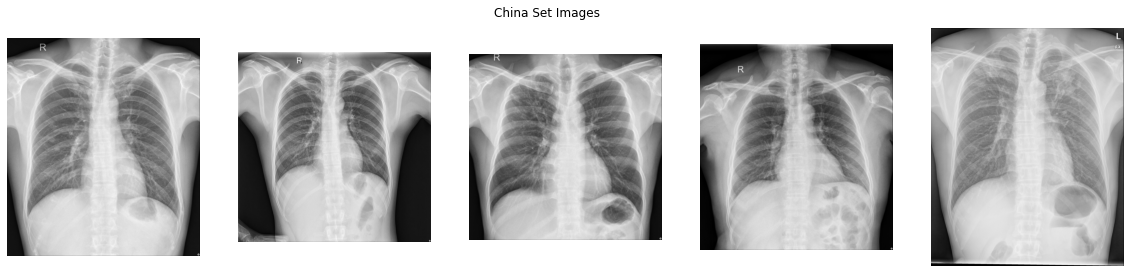

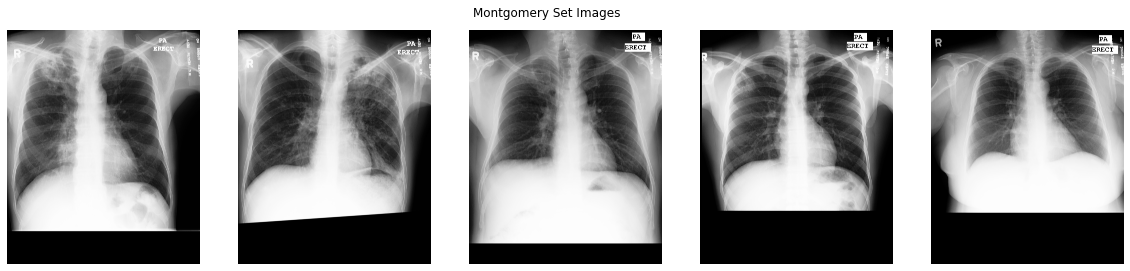

In [101]:
china_set_image_directory = china_set_extraction_location + '/ChinaSet_AllFiles/CXR_png/'
montgomery_set_image_directory = montgomery_set_extraction_location + '/MontgomerySet/CXR_png/'

showImagesHorizontally(5,china_set_image_directory, 'China Set Images')
showImagesHorizontally(5,montgomery_set_image_directory, 'Montgomery Set Images')


In [102]:
def crop_background(image_directory, save_directory, is_test):

  list_of_files = os.listdir(image_directory)
  loop_range = 5 if is_test else len(list_of_files)
  

  for i in range(loop_range): 

    if(list_of_files[i] != 'Thumbs.db'): # there is a .db file at the end of each image directory that needs to be avoided
      img = cv2.imread(image_directory + list_of_files[i])
      img = cv2.normalize(img,  img, 0, 255, cv2.NORM_MINMAX) # normalize image to pixel values between 0 and 255 - needed for thresholding 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      # threshold 
      thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
      hh, ww = thresh.shape

      # make bottom 2 rows black where they are white the full width of the image
      thresh[hh-3:hh, 0:ww] = 0

      # get bounds of white pixels
      white = np.where(thresh==255)
      xmin, ymin, xmax, ymax = np.min(white[1]), np.min(white[0]), np.max(white[1]), np.max(white[0])

      # crop the image at the bounds adding back the two blackened rows at the bottom
      crop = img[ymin:ymax+3, xmin:xmax]

      # save resulting masked image
      #cv2.imwrite('xray_chest_thresh.jpg', thresh)
      cv2.imwrite(save_directory + list_of_files[i], crop)

In [103]:
china_set_test_directory = '/content/china_set_test/'
montgomery_set_test_directory = '/content/montgomery_set_test/'

crop_background(china_set_image_directory, china_set_test_directory, True)
crop_background(montgomery_set_image_directory, montgomery_set_test_directory, True)

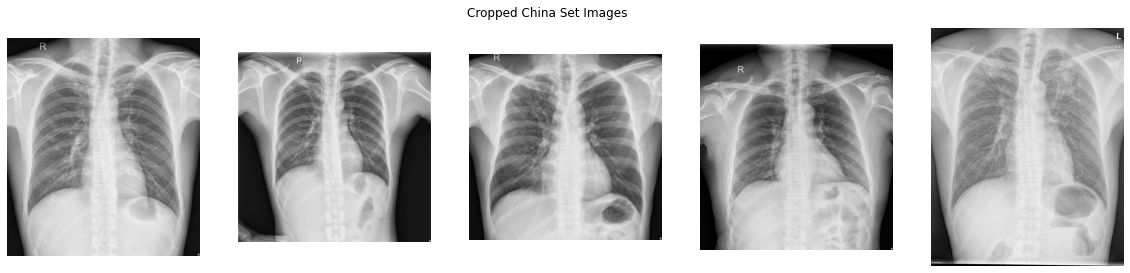

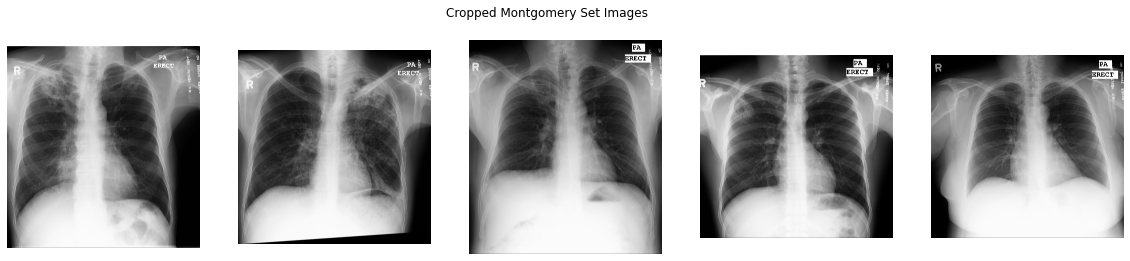

In [104]:
showImagesHorizontally(5, china_set_test_directory, 'Cropped China Set Images')
showImagesHorizontally(5, montgomery_set_test_directory, 'Cropped Montgomery Set Images')

In [98]:
def preprocess_images(image_directory):
  images = os.listdir(image_directory)

  for i in range(len(images)):


    img = cv2.imread(image_directory + images[i])

    # Global standardization of pixels
    pixels = np.asarray(img)
    pixels = pixels.astype('float32')
    mean, std = pixels.mean(), pixels.std()
    pixels = (pixels - mean) / std

    # normalizing image between 0 and 1
    norm_image = cv2.normalize(pixels, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

    cv2.imwrite(image_directory + 'image_' + str(i) + '.jpg', norm_image) #images need to be saved as jpegs - pngs will be displayed as black when normalized from 0-1

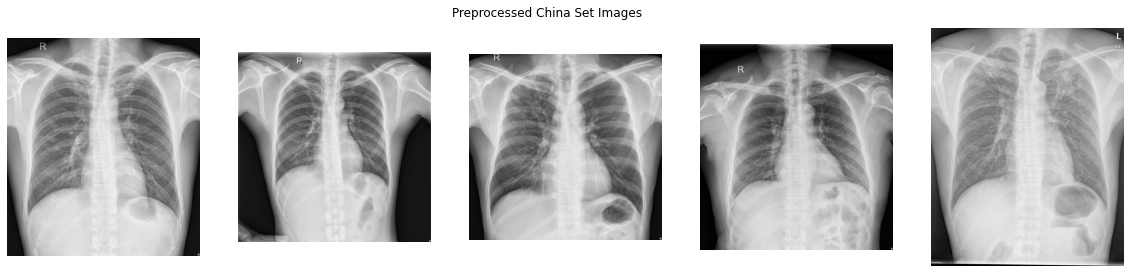

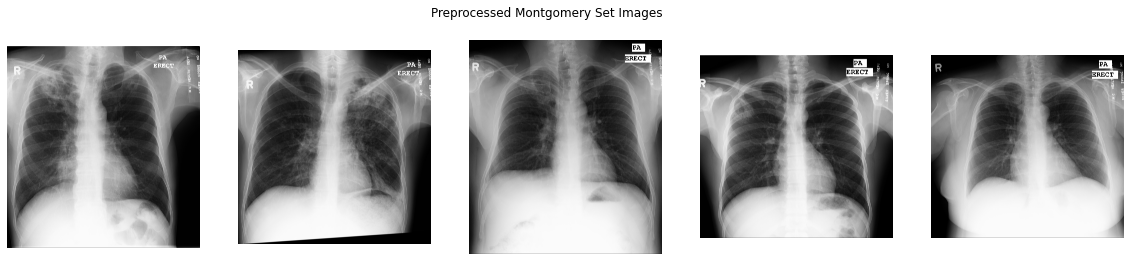

In [105]:
preprocess_images(china_set_test_directory)
preprocess_images(montgomery_set_test_directory)

showImagesHorizontally(5, china_set_test_directory, 'Preprocessed China Set Images')
showImagesHorizontally(5, montgomery_set_test_directory, 'Preprocessed Montgomery Set Images')